In [17]:
import pandas as pd
import json
import numpy as np
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
import pmdarima
from pmdarima import auto_arima
from sktime.datatypes._panel._convert import from_multi_index_to_nested

In [4]:
x = pd.read_csv(
        '../data_engineering/datasets/merged/rdc_data_merged_with_unemployment.csv',
        dtype={'month_day_yyymm': str, 'county_fip': str, 'quality_flag': str, 'unemployment_rate': float}, )
x.drop(x.tail(1).index, inplace=True)
x['date'] = x['month_date_yyyymm'].astype(str) + '01'

x['date'] = pd.to_datetime(x['date'], format="%Y%m%d")

# x = pd.read_csv("cleaned_data.csv",header=0)

# x["unemployment_rate"].fillna(x.unemployment_rate.mean(),inplace=True)
# x["active_listing_count"].fillna(x.active_listing_count.mean(),inplace=True)
# x["median_days_on_market"].fillna(x.median_days_on_market.mean(),inplace=True)

# x["median_listing_price"].interpolate(method='linear',inplace=True)
# x["unemployment_rate"].interpolate(method='linear',inplace=True)
# x["active_listing_count"].interpolate(method='linear',inplace=True)
# x["median_days_on_market"].interpolate(method='linear',inplace=True)


x['date'] = pd.to_datetime(x['date'])
x['county_name'] = x['county_name'].astype('category')
x['county_factor'] = pd.factorize(x['county_name'])[0]
x['date_factor'] = pd.factorize(x['date'])[0]

# x['date'] = x['date'].dt.strftime('%Y-%m')


/tmp/ipykernel_440/2750673848.py:1: DtypeWarning: Columns (0,1,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  x = pd.read_csv(


In [6]:
d = x[['date','date_factor','county_factor','county_name','county_fips','median_listing_price','unemployment_rate','active_listing_count','median_days_on_market']]
d.dropna(how='any',inplace=True)
d_train = d[d.date<"2021-07-01"]
d_test = d[d.date>="2021-04-01"]
d_train
d_train.set_index(['county_factor','date_factor'], inplace=True)
d_test.set_index(['county_factor','date_factor'], inplace=True)

/tmp/ipykernel_440/289312572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.dropna(how='any',inplace=True)


<AxesSubplot:title={'center':'median price'}, xlabel='county_factor,date_factor'>

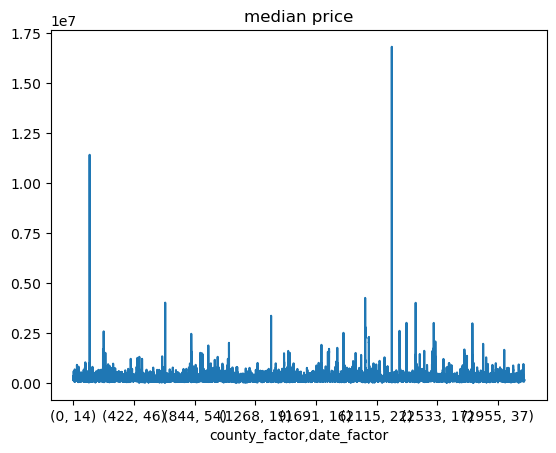

In [16]:
d_train['median_listing_price'].plot(title="median price")

In [7]:
from sktime import datatypes
# datatypes.check_raise(d_train[['median_listing_price']],mtype='pd.DataFrame', scitype='Panel')

In [8]:
# Gang Autoarima invoke for seasonal arima with exogeneous vars (SARIMAX hyperparams)
fuck_sktime = AutoARIMA(information_criterion='bic',suppress_warnings=True, stepwise=True,
    ).fit(y=d_train[['median_listing_price']],X=d_train[['unemployment_rate','active_listing_count','median_days_on_market']])


KeyboardInterrupt: 

<AxesSubplot:>

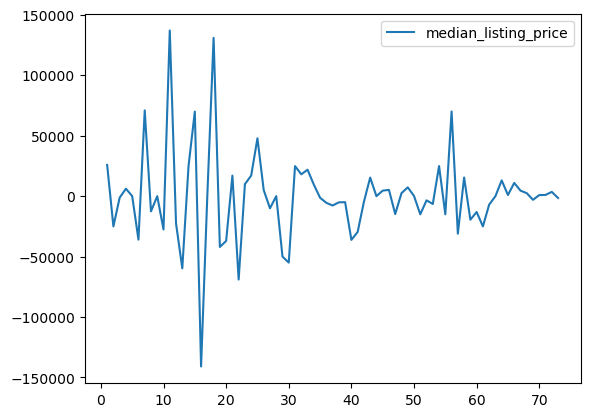

In [50]:
import matplotlib as mpl
x[x.county_name=='abbeville, sc'][['median_listing_price']].diff().plot()

In [ ]:
autofit = auto_arima(d.median_listing_price, 
                     xreg=d[['unemployment_rate','active_listing_count','county_name']], 
                     m=12, 
                     max_d=2,
                     max_D=2,
                    maxiter=50,
                    alpha=0.05,
                    n_jobs=-1,
                    trend='ct',
                    information_criterion='oob',
                     out_of_sample_size = int(len(d)*0.02)
                    )

/opt/conda/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
